# In-vivo evidence for increased tau deposition in temporal lobe epilepsy

### Content
1. Subcortical analysis
1. Hippocampal analysis
1. Mediation analysis
1. Sex analysis


In [1]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from brainspace.plotting import plot_hemispheres
from osfclient import OSF

# Load utilities functions from utils.py
from utils import *

### Fetch data

In [2]:
# Load the data frame
osf_df = osf_download("18F-MK6240_in-vivo_database.csv", project_id='ct3gw')
df = pd.read_csv(osf_df)

# Load processed 18F-MK6240 PET data | matrix:{vertices x subjects}
osf_pet_raw = osf_download("surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy", project_id='ct3gw')
pet_raw = np.load(osf_pet_raw)

# Load the cortical thickness data | matrix:{vertices x subjects}
osf_cth_raw = osf_download("surf-fsLR-32k_desc-GroupData_smooth-20mm_thickness.npy", project_id='ct3gw')
cth_raw = np.load(osf_cth_raw)

# Load fsLR-32 surface
fslr32k_lh = fetch_surface('fsLR-32k.L.surf.gii')
fslr32k_rh = fetch_surface('fsLR-32k.R.surf.gii')
fslr32k = fetch_template_surface("fslr32k", join=True)

# Load fsLR-32k middle wall mask
fslr32k_mask = fetch_mask("fslr32k")

Found file: 18F-MK6240_in-vivo_database.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12.3k/12.3k [00:00<00:00, 12.2Mbytes/s]


Downloaded 18F-MK6240_in-vivo_database.csv to /host/yeatman/local_raid/temporaryLocalProcessing/tmpptpyng69/18F-MK6240_in-vivo_database.csv
Found file: surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 28.6M/28.6M [00:00<00:00, 83.1Mbytes/s]


Downloaded surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy to /host/yeatman/local_raid/temporaryLocalProcessing/tmp63v142xm/surf-fsLR-32k_desc-GroupData_smooth-10mm_pvc-probGM_ref-cerebellarGM_trc-18Fmk6240_pet.npy
Found file: surf-fsLR-32k_desc-GroupData_smooth-20mm_thickness.npy


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 28.6M/28.6M [00:00<00:00, 79.0Mbytes/s]


Downloaded surf-fsLR-32k_desc-GroupData_smooth-20mm_thickness.npy to /host/yeatman/local_raid/temporaryLocalProcessing/tmpfuibj23d/surf-fsLR-32k_desc-GroupData_smooth-20mm_thickness.npy


### Sort the matrices into ipsilateral/contralateral relative to seizure focus

In [3]:
# fsLR-32k length
n_64k = pet_raw.shape[1]
n_32k = int(n_64k/2)

# Flip R >> L 18F-mk6240
mk_ipsi, mk_contra = flip_mat(pet_raw[:,0:n_32k], pet_raw[:,n_32k:n_64k], df['lateralization'].values, flip='R')

# Flip R >> L Thickness
th_ipsi, th_contra = flip_mat(cth_raw[:,0:n_32k], cth_raw[:,n_32k:n_64k], df['lateralization'].values, flip='R')

# Merge ipsi and contra
tauMK6240 = np.concatenate((mk_ipsi, mk_contra), axis=1)
thickness = np.concatenate((th_ipsi, th_contra), axis=1)


Flipping data from Right to Left
Flipping data from Right to Left


## Subcortical Analysis

## Hippocampal analysis

## Mediation analysis

## Sex analysis

### Females

In [4]:
# Cross-tabulation with rows = sex (M/F), columns = (group, mk6240.session)
cross_tab = pd.crosstab(
    index=df['sex'],
    columns=[df['group'], df['mk6240.session']],
    margins=False
)

# Display
display(cross_tab)

group          Healthy    Patient   
mk6240.session       1  2       1  2
sex                                 
F                    6  2       6  3
M                   14  5      12  7

Y ~ group + age + sex + 1/subject


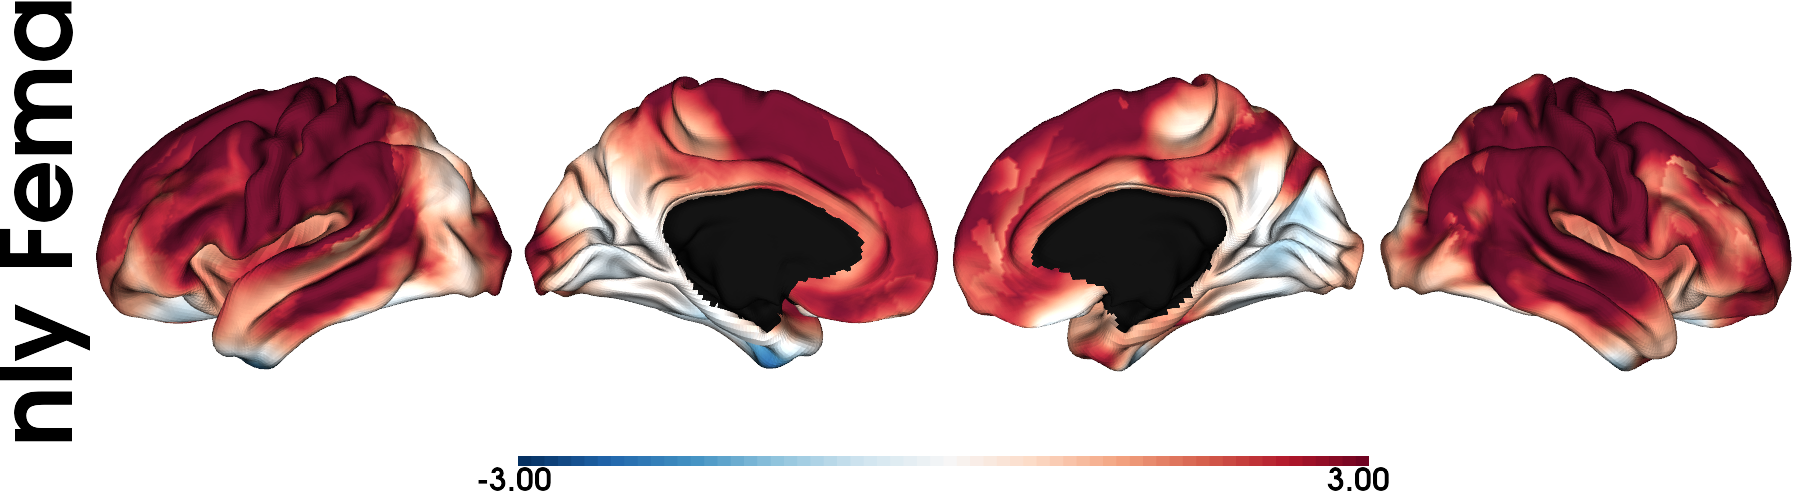

In [5]:
# Slice data
indx = df['sex'] == 'F'

# p>0.025 CREATE the mixed effects model
slm = mem_groups(Data=tauMK6240[indx,:], df=df[indx], Surf=fslr32k, mask=fslr32k_mask, Cthr=0.01, mem=True,  Pcorr="rft")

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm, color_range=(-3,3), Str='Only Female', Save=False, Col="RdBu_r", mask=fslr32k_mask,
            png_file='/home/bic/rcruces/Desktop/mk6240_tval.png', scale=1 )


### Males

Y ~ group + age + sex + 1/subject


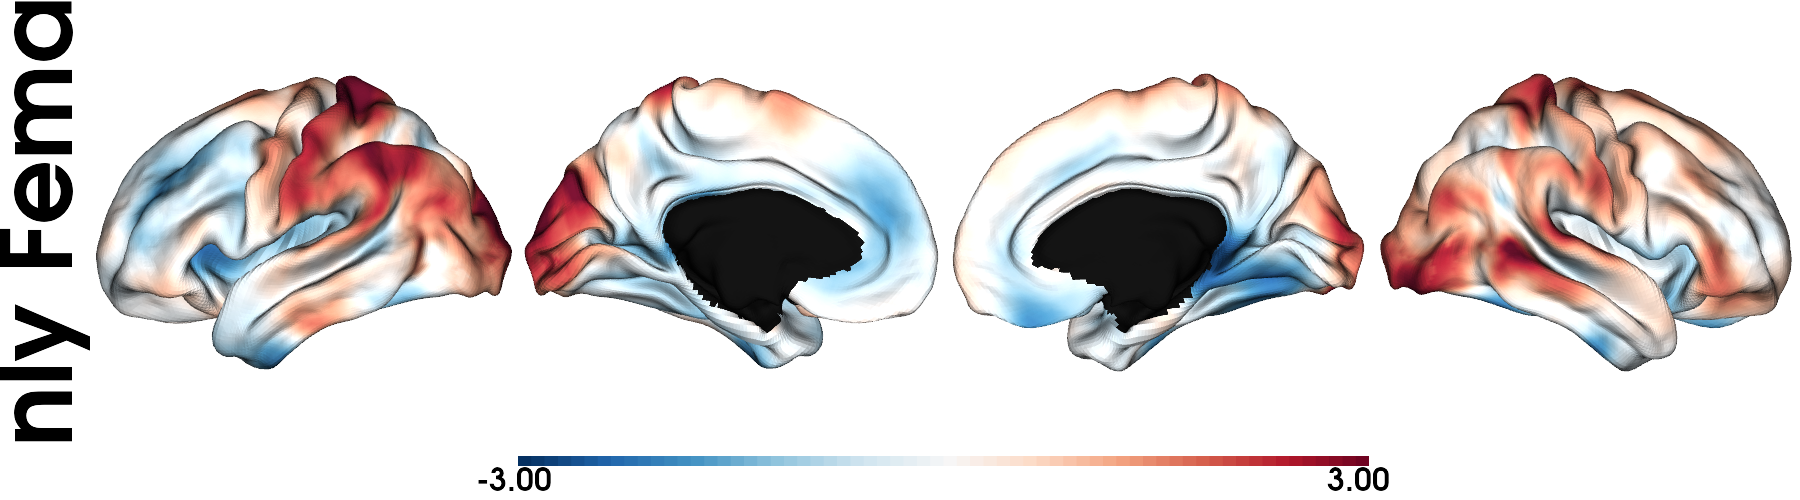

In [6]:
# Slice data
indx = df['sex'] == 'M'

# p>0.025 CREATE the mixed effects model
slm = mem_groups(Data=tauMK6240[indx,:], df=df[indx], Surf=fslr32k, mask=fslr32k_mask, Cthr=0.01, mem=True,  Pcorr="rft")

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm, color_range=(-3,3), Str='Only Female', Save=False, Col="RdBu_r", mask=fslr32k_mask,
            png_file='/home/bic/rcruces/Desktop/mk6240_tval.png', scale=2 )


Y ~ group + sex + group:sex + age + 1/subject


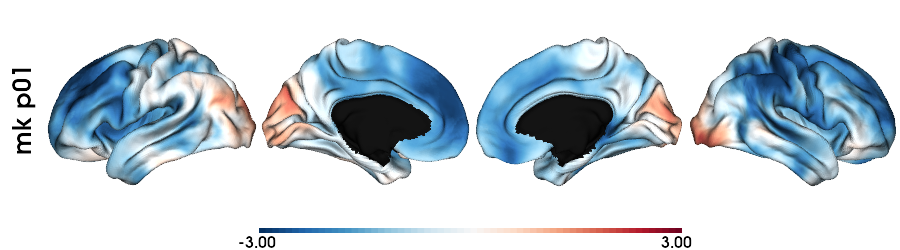

In [7]:
# Set the terms of the model
term_grp = FixedEffect(df['group'])
term_age = FixedEffect(df['age'])
term_sex = FixedEffect(df['sex'])
term_subject = MixedEffect(df['participant_id'])

# boolean masks
is_healthy = (df.group == 'Healthy')
is_patient = (df.group == 'Patient')
is_male = (df.sex == 'M')
is_female = (df.sex == 'F')

# Model is is mixed Subject is set as random Mixed effect variable
print("Y ~ group + sex + group:sex + age + 1/subject")
model = term_grp + term_grp*term_sex + term_age  + term_subject

# Group effect IN MALES  -> (Healthy_male) - (Patient_male)
contrast_group_male = (is_patient & is_male).astype(int) - (is_healthy & is_male).astype(int)

# fitting the model
slm_mixed = SLM(
        model,
        contrast_group_male,
        mask=fslr32k_mask,
        surf=fslr32k,
        correction="rft",
        two_tailed=True,
        cluster_threshold=0.01
    )
slm_mixed.fit(tauMK6240)

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm_mixed, color_range=(-3,3), Str='mk p01', Save=False, Col="RdBu_r", mask=fslr32k_mask, scale=1 )


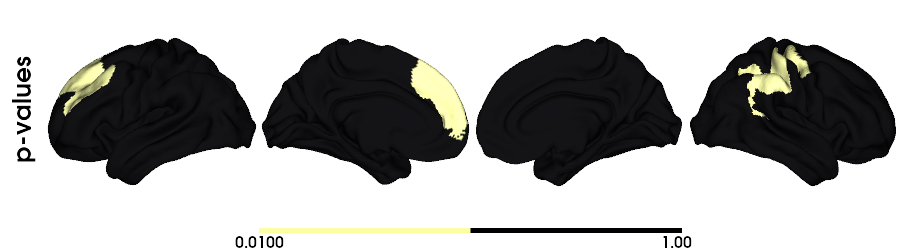

In [8]:
# p>0.025 Plot P-values
plot_ctx_pval(fslr32k_lh, fslr32k_rh, slm_mixed, Str='p-values', Col="inferno_r", Thr=0.01, scale=1)


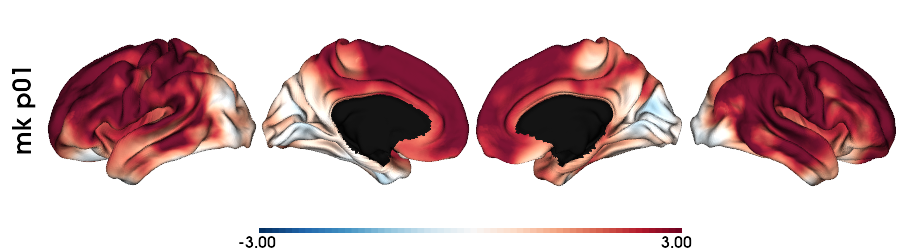

In [9]:
# Group effect IN FEMALES -> (Healthy_female) - (Patient_female)
contrast_group_female = (is_patient & is_female).astype(int) - (is_healthy & is_female).astype(int)

# fitting the model
slm_mixed = SLM(
        model,
        contrast_group_female,
        mask=fslr32k_mask,
        surf=fslr32k,
        correction="rft",
        two_tailed=True,
        cluster_threshold=0.01
    )
slm_mixed.fit(tauMK6240)

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm_mixed, color_range=(-3,3), Str='mk p01', Save=False, Col="RdBu_r", mask=fslr32k_mask, scale=1 )


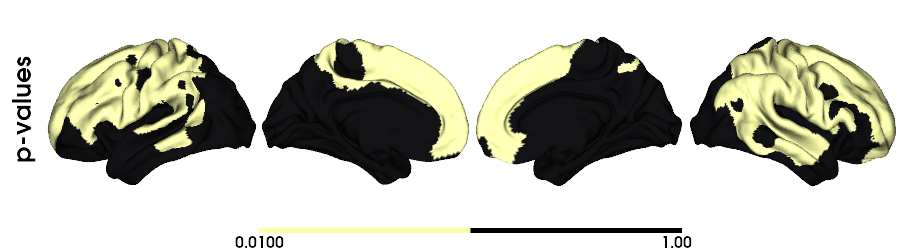

In [10]:
# p>0.025 Plot P-values
plot_ctx_pval(fslr32k_lh, fslr32k_rh, slm_mixed, Str='p-values', Col="inferno_r", Thr=0.01, scale=1)


### Interaction: difference in group effect (Female minus Male)

Y ~ group + sex + group:sex + age + 1/subject


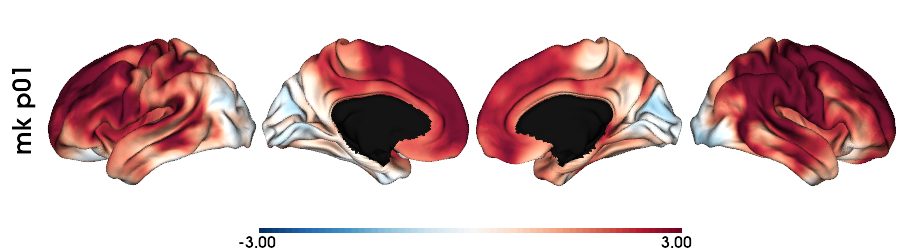

In [11]:
# Interaction: difference in group effect (Female minus Male)
contrast_interaction = contrast_group_female - contrast_group_male

# Model is is mixed Subject is set as random Mixed effect variable
print("Y ~ group + sex + group:sex + age + 1/subject")
model = term_grp + term_sex + term_grp*term_sex + term_age  + term_subject

# fitting the model
slm_mixed = SLM(
        model,
        contrast_interaction,
        mask=fslr32k_mask,
        surf=fslr32k,
        correction="rft",
        two_tailed=True,
        cluster_threshold=0.01
    )
slm_mixed.fit(tauMK6240)

# Plot t-values
plot_ctx_slm(fslr32k_lh, fslr32k_rh, slm_mixed, color_range=(-3,3), Str='mk p01', Save=False, Col="RdBu_r", mask=fslr32k_mask, scale=1 )



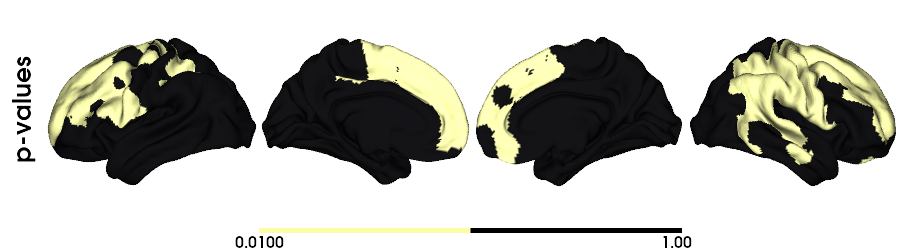

In [12]:
# p>0.025 Plot P-values
plot_ctx_pval(fslr32k_lh, fslr32k_rh, slm_mixed, Str='p-values', Col="inferno_r", Thr=0.01, scale=1)
